# Generalized Linear Models

### Environment Setup
**⚠️Note: If running on a new environment, run this cell once and then restart the kernel⚠️**

In [1]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

### Downloading Files

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-717038285/sub-717038285_ses-732592105.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.56.2) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Selecting Neurons

In [5]:
spike_times = nwb.units[0].spike_times.item()

### Selecting Stimulus Times

In [6]:
running_data = nwb.processing["running"]["running_speed"].data
running_timestamps = nwb.processing["running"]["running_speed"].timestamps

In [7]:
### interpolate running here:
interp_hz = running_timestamps[1] - running_timestamps[0] # set this
stim = running_data

### Building Design Matrix

In [8]:
ntfilt = 25

num_time_bins = len(stim)
num_spikes = len(spike_times)

In [9]:
def get_design_mat(ntfilt, stim, num_time_bins):
    padded_stim = np.hstack((np.zeros((ntfilt-1)), stim)) # pad early bins of stimulus with zero
    design_mat = np.zeros((num_time_bins,ntfilt))
    for j in np.arange(num_time_bins):
        design_mat[j] = padded_stim[j:j+ntfilt] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat

In [10]:
design_mat = get_design_mat(ntfilt, stim, num_time_bins)

### Getting STA

In [11]:

spikes_bin_centers = np.arange(num_time_bins+1) * interp_hz # centers of bins for applying to spike train
spikes_binned,_ = np.histogram(spike_times, spikes_bin_centers)

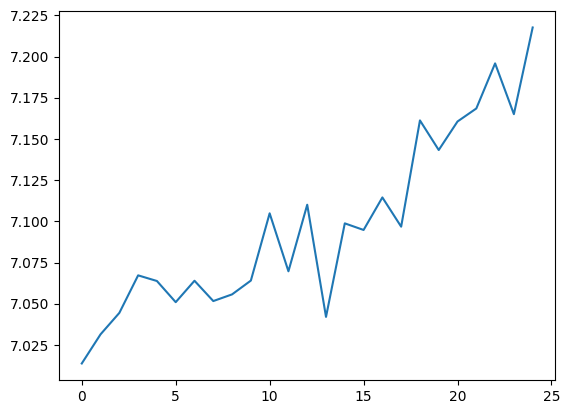

In [12]:
sta = (design_mat.T @ spikes_binned)/num_spikes
plt.plot(sta)

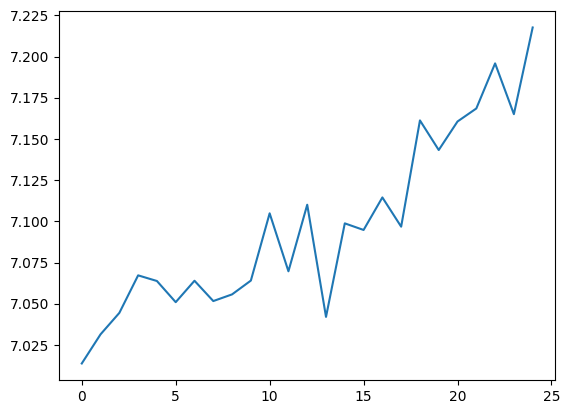

In [13]:
from numpy.linalg import inv
wsta = inv(design_mat.T @ design_mat) @ sta * num_spikes
plt.plot(sta)

### Running MLE

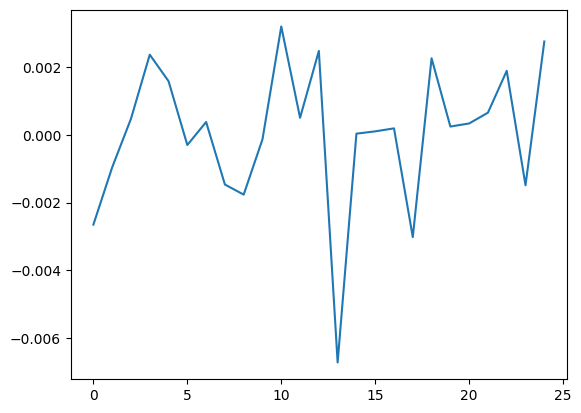

In [16]:
design_mat_offset = np.hstack((np.ones((num_time_bins,1)), design_mat))     # just add a column of ones

glm_poisson_exp = sm.GLM(endog=spikes_binned, exog=design_mat_offset,
                         family=sm.families.Poisson())

pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion='params')


# pGLM_const = glm_poisson_exp[-1].fit_['beta0'] # constant ("dc term)")
pGLM_const = pGLM_results.params[0]
pGLM_filt = pGLM_results.params[1:] # stimulus filter

plt.plot(pGLM_filt)